In [1]:
#Standard Packages:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.optimize import minimize

#Statsmodels:
import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.linear_model import LinearRegression
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf
from pandas.tseries.frequencies import to_offset

from contextualized.easy import ContextualizedRegressor
import plotly.graph_objects as go

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

def difference(series, order=1):
    diffed = series.copy()
    for _ in range(order):
        diffed = diffed.diff().dropna()
    return diffed

def invert_difference(last_original, differenced):
    return last_original + differenced

def create_lag_features(series, p_lags, q_lags):
    X_ar = pd.DataFrame(index=series.index)
    for lag in p_lags:
        X_ar[f'lag_{lag}'] = series.shift(lag)
    
    X_ma = pd.DataFrame(index=series.index)
    for lag in q_lags:
        X_ma[f'ma_{lag}'] = 0
    
    if len(q_lags) > 0:
        X = pd.concat([X_ar, X_ma], axis=1)
    else:
        X = X_ar

    X = X.dropna()
    y = series.loc[X.index]
    return X, y
    


In [3]:
from sklearn.linear_model import Ridge

def ARIMA(p, i, q, s, alpha=1.0):
    """
    Fit an ARIMA model with specified AR (p), differencing (i), and MA (q) lags.
    Uses Ridge Regression with specified regularization strength alpha.
    """
    if not isinstance(s, pd.Series):
        s = pd.Series(s)

    original_series = s.copy()
    differenced_series = difference(s, order=i)
    X, y = create_lag_features(differenced_series, p, q)

    if len(q) == 0:
        # No MA terms: fit immediately
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_
        residuals = y - regression_model.predict(X)
    else:
        # First fit AR part only to get residuals
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        ar_X = X[ar_cols]

        ar_model = Ridge(alpha=alpha)
        ar_model.fit(ar_X, y)
        ar_coef = ar_model.coef_
        intercept = ar_model.intercept_

        residuals = y - ar_model.predict(ar_X)

        # Create true MA features from residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]

        # Final fit with AR + MA features
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_

        preds = regression_model.predict(X)
        print(preds.shape)
        residuals = y - preds

    sigma2 = np.var(residuals)
    n = len(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'coef': coef,
        'intercept': intercept,
        'model': regression_model,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X,
        'y_train': y,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict


In [4]:
def ContextualisedARIMA(p, i, q, s, C, n_bootstraps=1, alpha=0.1):
    """
    Fit an ARIMA model with specified AR (p), differencing (i), and MA (q) lags.
    Includes an intercept and uses standard Linear Regression directly.
    """
    if not isinstance(s, pd.Series):
        s = pd.Series(s)

    original_series = s.copy()
    differenced_series = difference(s, order=i)
    X, y = create_lag_features(differenced_series, p, q)

    if len(q) == 0:
        # No MA terms: fit immediately
        regression_model = ContextualizedRegressor(n_bootstraps=n_bootstraps, alpha=alpha)
        regression_model.fit(C, X, y,
            encoder_type="mlp",
            max_epochs=10,
          learning_rate=1e-2)
        coefs, intercepts = regression_model.predict_params(C)
        residuals = y - regression_model.predict(C, X)
    else:
        # First fit AR part only to get residuals
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        ar_X = X[ar_cols]

        ar_model = Ridge(alpha=1)
        ar_model.fit(ar_X, y)
        ar_coef = ar_model.coef_
        intercept = ar_model.intercept_

        residuals = y - ar_model.predict(ar_X)

        # Create true MA features from residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]
        X_cols = X.columns

        C = C.loc[X.index].to_numpy()
        X_df = X
        X = X.to_numpy()
        y = y.to_numpy()

        # Final fit with AR + MA features
        regression_model = ContextualizedRegressor(n_bootstraps=n_bootstraps, alpha=alpha)
        regression_model.fit(C, X, y,
            encoder_type="mlp",
            max_epochs=10,
          learning_rate=1e-2)
        coefs, intercepts = regression_model.predict_params(C)
        preds = regression_model.predict(C, X).flatten()
        print(preds.shape)
        residuals = y - preds
        residuals = pd.Series(residuals, index=X_df.index)

    sigma2 = np.var(residuals)
    n = len(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'coefs': coefs,
        'intercepts': intercepts,
        'model': regression_model,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X_cols,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X_df,
        'y_train': y,
        'C_train': C,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict

In [5]:
def forecast(model_dict, steps=1):
    """
    Forecast future values based on the fitted ARIMA model with selected lags.
    This function produces forecasts one-step ahead, iteratively.
    """
    p_lags = model_dict['p']  # p is a list of AR lags
    i = model_dict['i']
    q_lags = model_dict['q']  # q is a list of MA lags
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    
    # Current "history" for differenced series
    differenced_series = model_dict['differenced_series']
    
    forecasts = []
    
    # We keep track of recent differenced values and residuals
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    for _ in range(steps):
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(current_diff) - lag >= 0:
                ar_features.append(current_diff.iloc[-lag])
            else:
                ar_features.append(np.nan)
        
        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(current_resid) - lag >= 0:
                ma_features.append(current_resid.iloc[-lag])
            else:
                # For future predictions, we assume residuals are 0 if not available
                ma_features.append(0.0)
        
        # Combine AR and MA features in the same order as training
        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)
        
        # Predict the differenced value
        diff_forecast = model.predict(X_pred)[0]
        
        # Update the differenced series and residuals
        # Generate a new index for the forecast step
        if isinstance(current_diff.index[-1], (int, float)):
            new_index = current_diff.index[-1] + 1
        else:
            # If it's a time index, step by frequency
            new_index = current_diff.index[-1] + pd.Timedelta(f)
        
        current_diff = pd.concat([current_diff, pd.Series([diff_forecast], index=[new_index])])
        current_resid = pd.concat([current_resid, pd.Series([0.0], index=[new_index])])
        
        # Invert differencing
        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")
        
        last_original_value = original_series.iloc[-1] if len(forecasts) == 0 else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [6]:
def rolling_forecast(model_dict, true_series):
    """
    Perform a rolling forecast: predict one step ahead, then observe true value and update history.
    """
    from pandas.tseries.frequencies import to_offset

    p_lags = model_dict['p']
    i = model_dict['i']
    q_lags = model_dict['q']
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series'].copy()
    differenced_series = model_dict['differenced_series'].copy()
    residuals = model_dict['residuals'].copy()
    print(residuals)

    start_idx = original_series.index[-1]
    true_series = true_series[true_series.index > start_idx]

    forecasts = []

    for t_idx in true_series.index:
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(differenced_series) - lag >= 0:
                ar_features.append(differenced_series.iloc[-lag])
            else:
                ar_features.append(np.nan)

        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(residuals) - lag >= 0:
                ma_features.append(residuals.iloc[-lag])
            else:
                ma_features.append(0.0)

        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)

        diff_forecast = model.predict(X_pred)[0]
        print(type(diff_forecast))

        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")

        last_original_value = original_series.iloc[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)

        # Update history:
        if t_idx in true_series.index:
            true_value = true_series.loc[t_idx]
        else:
            true_value = inv_forecast

        # Update series with the "observed" value
        original_series = pd.concat([original_series, pd.Series([true_value], index=[t_idx])])
        new_diff = true_value - last_original_value
        differenced_series = pd.concat([differenced_series, pd.Series([new_diff], index=[t_idx])])

        resid = true_value - inv_forecast
        residuals = pd.concat([residuals, pd.Series([resid], index=[t_idx])])

    return forecasts


In [7]:
def c_forecast(model_dict, C, steps=1):
    """
    Forecast future values based on the fitted ARIMA model with selected lags.
    This function produces forecasts one-step ahead, iteratively.
    """
    p_lags = model_dict['p']  # p is a list of AR lags
    i = model_dict['i']
    q_lags = model_dict['q']  # q is a list of MA lags
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    
    # Current "history" for differenced series
    differenced_series = model_dict['differenced_series']
    
    forecasts = []
    
    # We keep track of recent differenced values and residuals
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    for _ in range(steps):
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(current_diff) - lag >= 0:
                ar_features.append(current_diff.iloc[-lag])
            else:
                ar_features.append(np.nan)
        
        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(current_resid) - lag >= 0:
                ma_features.append(current_resid.iloc[-lag])
            else:
                # For future predictions, we assume residuals are 0 if not available
                ma_features.append(0.0)
        
        # Combine AR and MA features in the same order as training
        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)

        C_pred = C.loc[[_]].to_numpy()
        
        # Predict the differenced value
        diff_forecast = model.predict(C, X_pred)[0]
        
        # Update the differenced series and residuals
        # Generate a new index for the forecast step
        if isinstance(current_diff.index[-1], (int, float)):
            new_index = current_diff.index[-1] + 1
        else:
            # If it's a time index, step by frequency
            new_index = current_diff.index[-1] + pd.Timedelta('1D')
        
        current_diff = pd.concat([current_diff, pd.Series([diff_forecast], index=[new_index])])
        current_resid = pd.concat([current_resid, pd.Series([0.0], index=[new_index])])
        
        # Invert differencing
        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")
        
        last_original_value = original_series.iloc[-1] if len(forecasts) == 0 else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [8]:
def c_forecast(model_dict, C, steps=1):
    """
    Forecast future values using a contextualised ARIMA model.
    Produces forecasts one-step ahead, iteratively.
    """
    p_lags = model_dict['p']
    i = model_dict['i']
    q_lags = model_dict['q']
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    differenced_series = model_dict['differenced_series']
    
    forecasts = []
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    # Assume C is indexed by date and aligned with future steps
    future_context = C.iloc[:steps].copy()  # Get the required context rows
    
    for step in range(steps):
        # Build AR features
        ar_features = [current_diff.iloc[-lag] if len(current_diff) >= lag else np.nan for lag in p_lags]
        
        # Build MA features
        ma_features = [current_resid.iloc[-lag] if len(current_resid) >= lag else 0.0 for lag in q_lags]
        
        # Build input for the model
        X_pred = pd.DataFrame([ar_features + ma_features], columns=X_cols).astype(float).to_numpy()
        C_pred = future_context.iloc[[step]].to_numpy()
        
        # Make prediction
        diff_forecast = model.predict(C_pred, X_pred)[0]
        
        # Extend differenced and residuals series
        if isinstance(current_diff.index[-1], (int, float)):
            new_index = current_diff.index[-1] + 1
        else:
            new_index = current_diff.index[-1] + pd.Timedelta('1D')
        
        current_diff.loc[new_index] = diff_forecast
        current_resid.loc[new_index] = 0.0  # Assumes 0 residuals for future
        
        # Invert differencing (only 1st order supported)
        last_original_value = original_series.iloc[-1] if not forecasts else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [9]:
def c_rolling_forecast(model_dict, true_series, C):
    """
    Perform a rolling forecast: predict one step ahead, then observe true value and update history.
    """
    from pandas.tseries.frequencies import to_offset

    p_lags = model_dict['p']
    i = model_dict['i']
    q_lags = model_dict['q']
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series'].copy()
    differenced_series = model_dict['differenced_series'].copy()
    residuals = model_dict['residuals'].copy()

    start_idx = original_series.index[-1]
    true_series = true_series[true_series.index > start_idx]

    forecasts = []

    for t_idx in true_series.index:
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(differenced_series) - lag >= 0:
                ar_features.append(differenced_series.iloc[-lag])
            else:
                ar_features.append(np.nan)

        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(residuals) - lag >= 0:
                ma_features.append(residuals.iloc[-lag])
            else:
                ma_features.append(0.0)

        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols).to_numpy() 

        # get Contextual features
        C_pred = C.loc[[t_idx]].to_numpy() 
        #print(X_pred)
        #print(C_pred)

        diff_forecast = model.predict(C_pred,X_pred).item()

        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")

        last_original_value = original_series.iloc[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)

        # Update history:
        if t_idx in true_series.index:
            true_value = true_series.loc[t_idx]
        else:
            true_value = inv_forecast

        # Update series with the "observed" value
        original_series = pd.concat([original_series, pd.Series([true_value], index=[t_idx])])
        new_diff = true_value - last_original_value
        differenced_series = pd.concat([differenced_series, pd.Series([new_diff], index=[t_idx])])

        resid = true_value - inv_forecast
        residuals = pd.concat([residuals, pd.Series([resid], index=[t_idx])])

    return forecasts


In [10]:
def get_significant_acf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    acf_vals, confint = acf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(acf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

def get_significant_pacf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    pacf_vals, confint = pacf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(pacf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

In [11]:
# read daily close price data
file_path1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv'
file_path2 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_quarterly_ratiodata_alltime.csv' # Fundamental ratios (Compustat)

df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)

# Ensure that the date column is in datetime format
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')
df2['qdate'] = pd.to_datetime(df2['qdate'])  # Financial ratios data
# Sort by qdate and public_date to ensure the most recent public_date comes last
df2_sorted = df2.sort_values(by=['qdate', 'public_date'])
# Drop duplicates to keep only the latest public_date for each qdate
df2_latest = df2_sorted.drop_duplicates(subset='qdate', keep='last')
# Make a copy to avoid modifying the original df3_latest
df2_latest_pct = df2_latest.copy()
# Select columns to calculate percentage change, excluding identifier and date columns
columns_to_change = ['npm', 'de_ratio', 'curr_ratio', 'ptb'] # Apply pct_change to each selected column and multiply by 100 to express as percentage
df2_latest_pct[columns_to_change] = df2_latest[columns_to_change].pct_change()

df = pd.merge_asof(
    df1,  # Daily data sorted by date
    df2_latest_pct,  # Fundamental data sorted by quarterly date
    left_on='date', right_on='qdate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Convert df to a Pandas Series using the 'PRC' column
f = 'W-SUN' # 'W-SUN' means week ending on Sunday
df = df.resample(f).last()
df = df.dropna()

start_date = '2003-1-30'
end_train_date = '2018-9-30'
end_date = '2025-12-24'

# Filter the data according to the date range
df = df[(df.index >= start_date) & (df.index <= end_date)]
df_train = df[(df.index >= start_date) & (df.index <= end_train_date)]
df_test = df[(df.index > df_train.index[-1]) & (df.index < end_date)]

df_test.tail()

,PERMNO,TICKER_x,BIDLO,ASKHI,PRC,VOL,RET,OPENPRC,permno,adate,qdate,public_date,npm,de_ratio,curr_ratio,ptb,TICKER_y
date,,,,,,,,,,,,,,,,,
2023-12-03,11850.0,XOM,102.22,104.2200,102.99,17845276.0,0.002433,102.50,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-10,11850.0,XOM,98.75,99.7867,99.55,22074945.0,0.011481,99.02,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-17,11850.0,XOM,100.31,101.0000,100.90,55527018.0,-0.006694,100.59,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-24,11850.0,XOM,101.82,102.9400,101.91,12927831.0,0.001769,102.31,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-31,11850.0,XOM,99.62,100.5900,99.98,17746408.0,-0.002096,100.37,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM


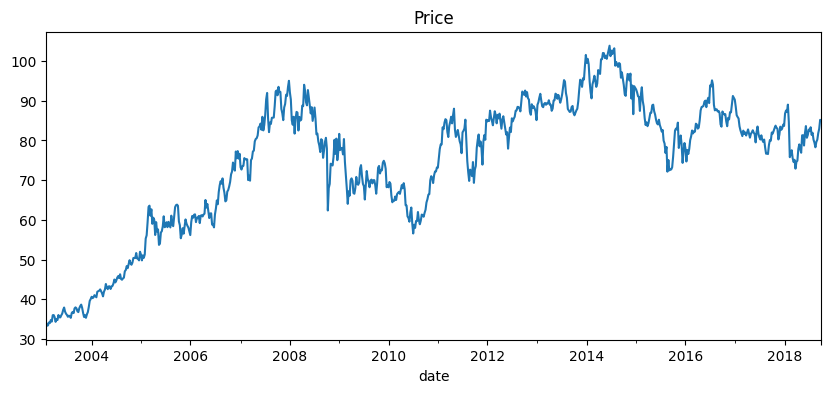

In [12]:
s = df['PRC']
s_train = df_train['PRC']
s_test = df_test['PRC']

C_df = df[['npm', 'de_ratio', 'curr_ratio', 'ptb']]
C_train = df_train[['npm', 'de_ratio', 'curr_ratio', 'ptb']]
C_test = df_test[['npm', 'de_ratio', 'curr_ratio', 'ptb']]

# Plot the series
s_train.plot(title='Price', figsize=(10, 4))
plt.show()


In [13]:
s_train.describe()
s_train.head()

date
2003-02-02    34.15
2003-02-09    33.35
2003-02-16    33.44
2003-02-23    34.18
2003-03-02    34.02
Freq: W-SUN, Name: PRC, dtype: float64

In [14]:
C_test.head()

,npm,de_ratio,curr_ratio,ptb
date,,,,
2018-10-07,0.05,-0.015532,-0.00489,-0.094543
2018-10-14,0.05,-0.015532,-0.00489,-0.094543
2018-10-21,0.05,-0.015532,-0.00489,-0.094543
2018-10-28,0.05,-0.015532,-0.00489,-0.094543
2018-11-04,0.05,-0.015532,-0.00489,-0.094543


In [15]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(s_train)
# Print the result of the ADF test
#print("ADF Statistic:", adf_result[0])
#print("p-value:", adf_result[1])
#print("Used Lag:", adf_result[2])
#print("Number of Observations Used:", adf_result[3])
#print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")

Conclusion: The series is non-stationary


In [16]:
# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(s)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")

Optimal number of differences (d): 1


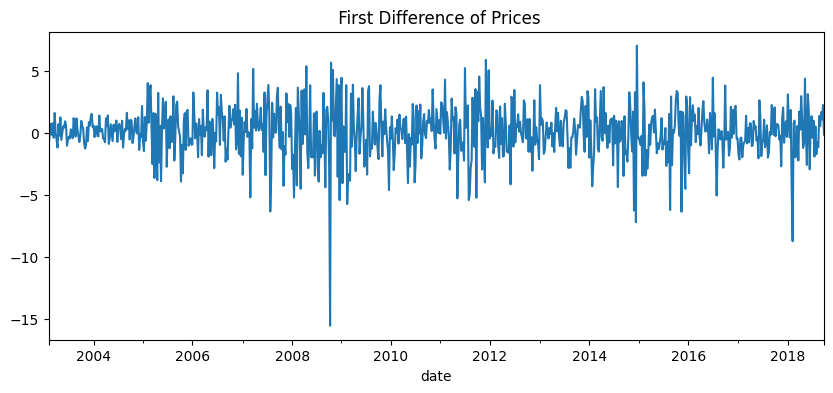

In [17]:
s_train_diffed = difference(s_train)

s_train_diffed.plot(title=' First Difference of Prices', figsize=(10, 4))
plt.show()

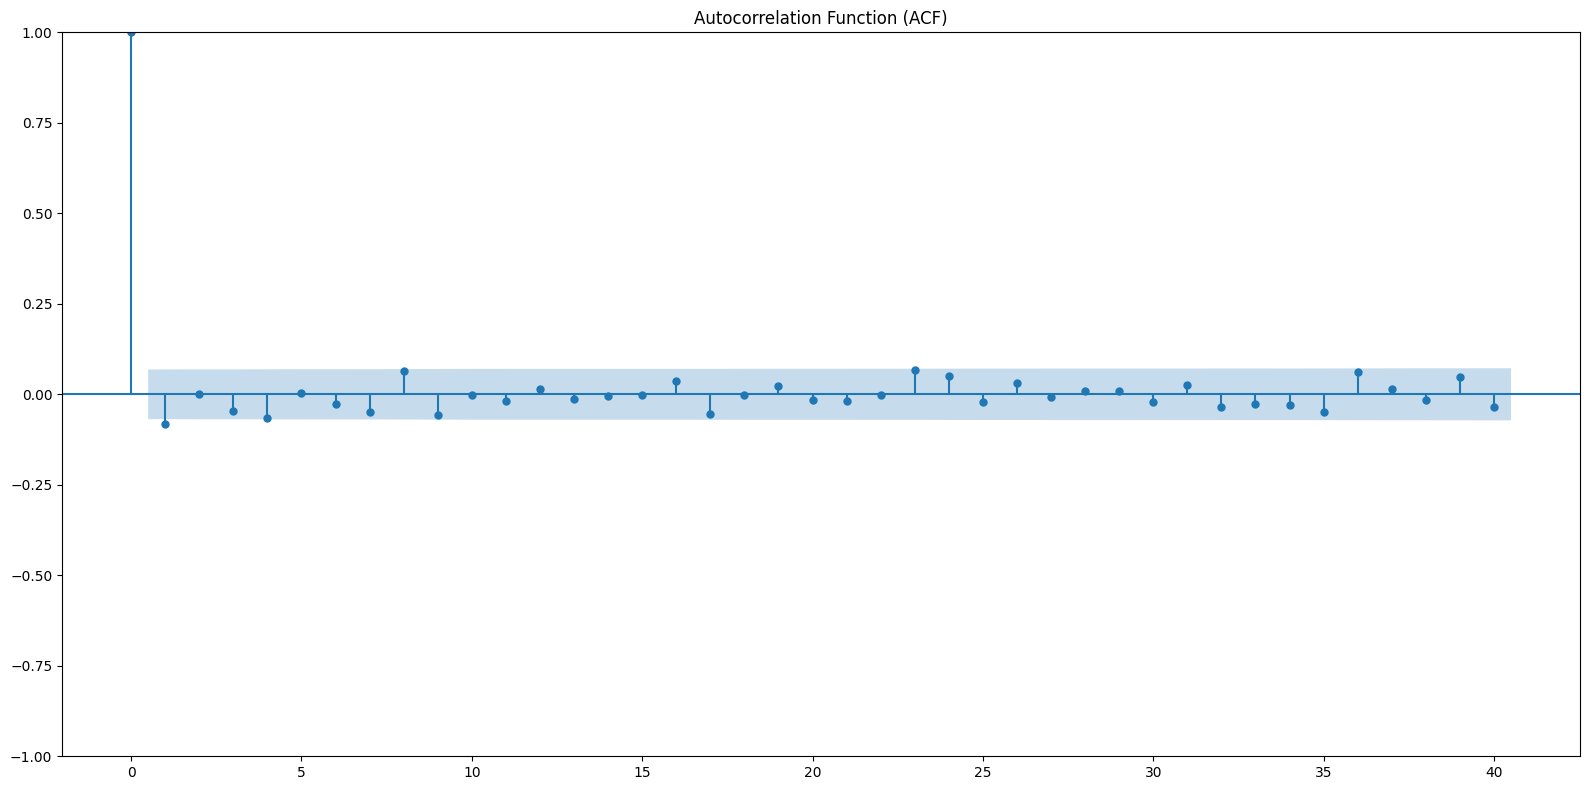

Significant ACF lags:
[1]


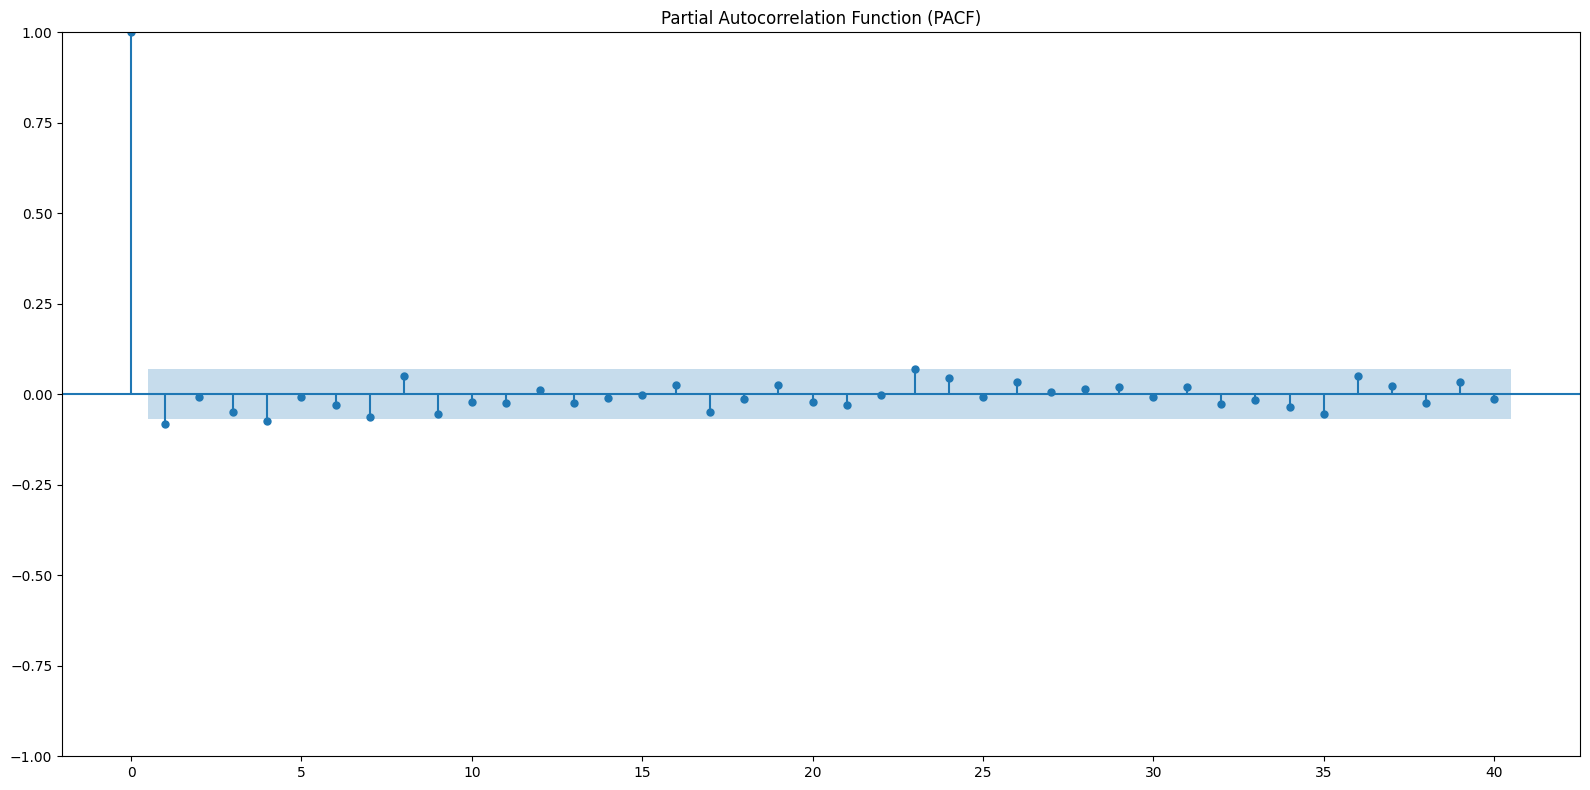

Significant PACF lags:
[1, 4, 23]


In [18]:
# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()
ax.set_title('Autocorrelation Function (ACF) of the First Difference')

# Print the significant lags
q = get_significant_acf_lags(s_train_diffed)
print("Significant ACF lags:")
print(q)

# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_pacf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
ax.set_title('Partial Autocorrelation Function (PACF) of the First Difference')

# Print the significant lags
p = get_significant_pacf_lags(s_train_diffed)

print("Significant PACF lags:")
print(p)

In [19]:
print(C_train.shape)
C_train

(818, 4)


,npm,de_ratio,curr_ratio,ptb
date,,,,
2003-02-02,0.050847,0.046680,0.000000,0.031512
2003-02-09,0.050847,0.046680,0.000000,0.031512
2003-02-16,0.050847,0.046680,0.000000,0.031512
2003-02-23,0.050847,0.046680,0.000000,0.031512
2003-03-02,0.050847,0.046680,0.000000,0.031512
...,...,...,...,...
2018-09-02,-0.036145,-0.012972,-0.006075,-0.018680
2018-09-09,-0.036145,-0.012972,-0.006075,-0.018680
2018-09-16,-0.036145,-0.012972,-0.006075,-0.018680


In [20]:
#p = [2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 24, 30]

p = list(range(1,30))
q = list(range(1,10))

# Fit the ARIMA model
model_dict = ARIMA(p=p, i=1, q=q, s=s_train, alpha=10)  # ARIMA returns a model_dict

# Access and print the learned parameters
coef = model_dict['coef']  # Coefficients of the AR and MA terms
intercept = model_dict['intercept']  # Intercept of the linear model
X_cols = model_dict['X_cols']  # Column names of the features (lags)

# Display the parameters
print("Learned Parameters:")
print(f"Intercept: {intercept:.4f}")
print("Coefficients:")
for col, weight in zip(X_cols, coef):
    print(f"{col}: {weight:.4f}")


(779,)
Learned Parameters:
Intercept: 0.1018
Coefficients:
lag_1: -0.0603
lag_2: 0.0444
lag_3: -0.0038
lag_4: -0.0798
lag_5: -0.0381
lag_6: -0.3238
lag_7: -0.0171
lag_8: 0.0855
lag_9: -0.2614
lag_10: -0.0588
lag_11: -0.0263
lag_12: -0.0026
lag_13: -0.0513
lag_14: 0.0028
lag_15: -0.0228
lag_16: 0.0093
lag_17: -0.0424
lag_18: -0.0170
lag_19: 0.0215
lag_20: -0.0188
lag_21: -0.0225
lag_22: 0.0091
lag_23: 0.0607
lag_24: 0.0460
lag_25: 0.0075
lag_26: 0.0149
lag_27: -0.0032
lag_28: 0.0250
lag_29: 0.0372
ma_1: -0.0252
ma_2: -0.0566
ma_3: -0.0542
ma_4: 0.0038
ma_5: 0.0315
ma_6: 0.2950
ma_7: -0.0648
ma_8: -0.0418
ma_9: 0.2017


<class 'pandas.core.series.Series'>


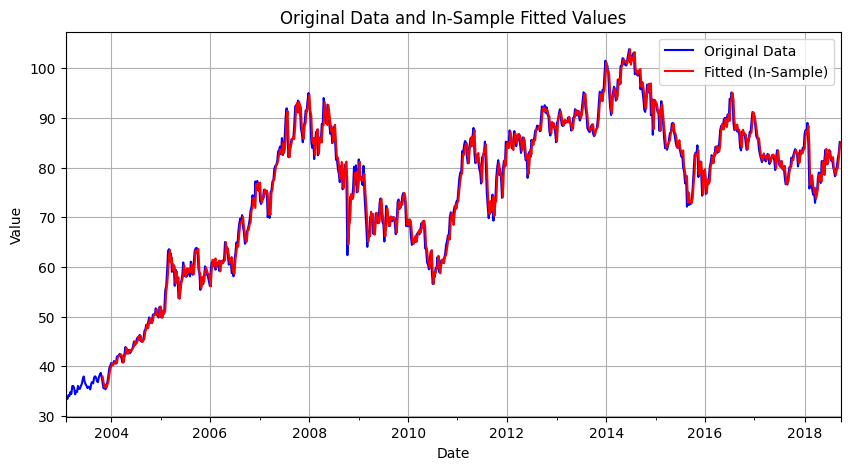

In [21]:
model = model_dict['model']
X_cols = model_dict['X_cols']
original_series = model_dict['original_series']
differenced_series = model_dict['differenced_series']
i = model_dict['i']  # differencing order
X = model_dict['X_train']
y = model_dict['y_train']

p_lags = model_dict['p']
q_lags = model_dict['q']
residuals = model_dict['residuals']

# Predict on the differenced scale (in-sample predictions)
fitted_diff = model.predict(X)

print(type(residuals))

# Invert differencing (assuming i=1)
if i > 1:
    raise NotImplementedError("Multiple differencing inversion not implemented.")

fitted_diff_series = pd.Series(fitted_diff, index=X.index, name='FittedDiff')

# To invert differencing:
# original_series[t] = original_series[t-1] + differenced_prediction[t]

# Get the initial value before the first fitted point
first_date = fitted_diff_series.index[0]
one_step_before = original_series.index.get_loc(first_date) - 1
initial_value = original_series.iloc[one_step_before]

fitted_original_values = []
current_value = initial_value
for idx in fitted_diff_series.index:
    current_value = current_value + fitted_diff_series.loc[idx]
    fitted_original_values.append(current_value)
    current_value = original_series.loc[idx]

fitted_original_series = pd.Series(fitted_original_values, index=fitted_diff_series.index, name='Fitted')

# Plot the original data and fitted values
plt.figure(figsize=(10,5))
original_series.plot(label='Original Data', color='blue')
fitted_original_series.plot(label='Fitted (In-Sample)', color='red')

plt.title("Original Data and In-Sample Fitted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

date
2003-11-02   -1.310528
2003-11-09   -1.181364
2003-11-16    0.226381
2003-11-23   -0.949793
2003-11-30    0.523400
                ...   
2018-09-02    0.564894
2018-09-09    1.927947
2018-09-16    1.224678
2018-09-23    1.386844
2018-09-30   -0.034531
Freq: W-SUN, Name: PRC, Length: 779, dtype: float64
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.floa

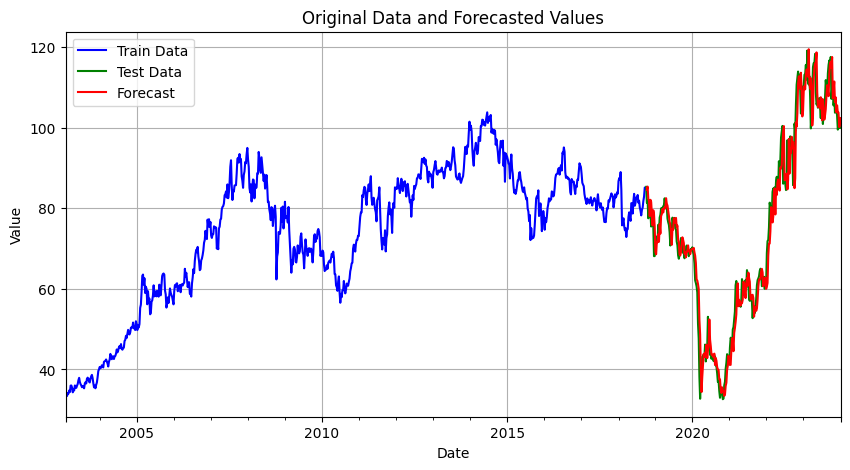

In [22]:
preds = rolling_forecast(model_dict, s)

# Get the first timestamp
start = s_test.index[1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start, periods=len(preds), freq=f)

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
mypred_series = pred_series
#print(pred_series)

# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Train Data', color='blue')
s_test.plot(ax=ax, label='Test Data', color='green')
pred_series.plot(ax=ax, label='Forecast', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()



In [23]:
# Fit the ARIMA model
p = list(range(1,30))
q = list(range(1,10))

c_model_dict = ContextualisedARIMA(p=p, i=1, q=q, s=s_train, C=C_train, n_bootstraps=10, alpha=0.1)  # ARIMA returns a model_dict

# Access and print the learned parameters
#c_coefs = c_model_dict['coefs']  # Coefficients of the AR and MA terms
#c_intercepts = c_model_dict['intercepts']  # Intercept of the linear model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-05-15 22:57:54.087313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/edocampione/Desktop/Meng Engineering Science/4YP/models/lightning_logs/boot_0_checkpoints exists and is not empty.

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | metamodel | NaiveMetamodel | 2.4 K  | train
-----------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total

In [ ]:
from contextualized.utils import save, load

#save(c_model, path='/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/contextualARIMA.pt')


In [ ]:
c_model = c_model_dict['model']
#c_model = load('/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/contextualARIMA.pt')
c_X_cols = c_model_dict['X_cols']
original_series = c_model_dict['original_series']
differenced_series = c_model_dict['differenced_series']
i = c_model_dict['i']  # differencing order
X = c_model_dict['X_train']
y = c_model_dict['y_train']
C = c_model_dict['C_train']

p_lags = c_model_dict['p']
q_lags = c_model_dict['q']
residuals = c_model_dict['residuals']

print(X.tail(1))

#residuals = pd.Series(residuals, index=X.index)
print(residuals)


            lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
date                                                                        
2018-09-30   2.25   1.09   1.66   0.55   1.36  -1.16  -0.78  -1.72   0.52   

            lag_10  ...  lag_29      ma_1      ma_2      ma_3     ma_4  \
date                ...                                                  
2018-09-30   -1.91  ...   -0.99  0.850736  1.460636  2.071246  1.52275   

                ma_5      ma_6      ma_7      ma_8      ma_9  
date                                                          
2018-09-30 -0.486474 -1.740977  1.014503 -2.473981  1.856146  

[1 rows x 38 columns]
date
2017-11-05    0.605225
2017-11-12   -0.085254
2017-11-19   -1.828917
2017-11-26    0.980200
2017-12-03    1.207829
2017-12-10   -0.169714
2017-12-17    1.022671
2017-12-24   -0.260092
2017-12-31    0.496191
2018-01-07    3.067969
2018-01-14   -0.520707
2018-01-21    0.657363
2018-01-28    1.257586
2018-02-04   -3.610770
2018-0

date
2017-11-05    0.605225
2017-11-12   -0.085254
2017-11-19   -1.828917
2017-11-26    0.980200
2017-12-03    1.207829
2017-12-10   -0.169714
2017-12-17    1.022671
2017-12-24   -0.260092
2017-12-31    0.496191
2018-01-07    3.067969
2018-01-14   -0.520707
2018-01-21    0.657363
2018-01-28    1.257586
2018-02-04   -3.610770
2018-02-11   -6.330298
2018-02-18    0.311506
2018-02-25   -0.019201
2018-03-04    0.146819
2018-03-11   -1.263947
2018-03-18   -0.363864
2018-03-25   -1.311781
2018-04-01    0.627475
2018-04-08   -0.733869
2018-04-15    1.276535
2018-04-22   -0.878930
2018-04-29    0.139922
2018-05-06    0.785392
2018-05-13    1.710424
2018-05-20    0.089980
2018-05-27   -1.642065
2018-06-03    2.459551
2018-06-10    1.224276
2018-06-17   -0.968746
2018-06-24    0.272909
2018-07-01   -0.358694
2018-07-08   -0.455572
2018-07-15    0.034955
2018-07-22   -0.658161
2018-07-29    1.252459
2018-08-05   -3.354114
2018-08-12    0.993444
2018-08-19   -1.231095
2018-08-26   -0.106512
2018-0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



(48,)


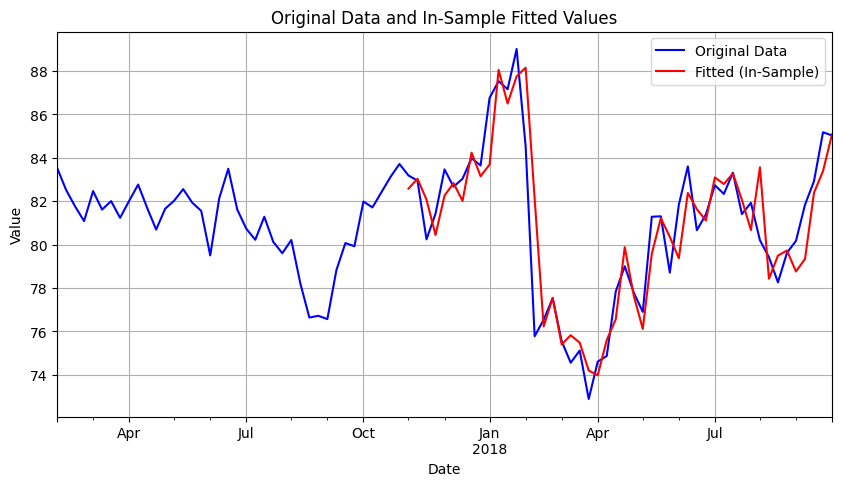

In [ ]:
print(residuals)

# Predict on the differenced scale (in-sample predictions)
fitted_diff = c_model.predict(C, X.to_numpy()).flatten()
print(fitted_diff.shape)

# Invert differencing (assuming i=1)
if i > 1:
    raise NotImplementedError("Multiple differencing inversion not implemented.")

fitted_diff_series = pd.Series(fitted_diff, index=X.index, name='FittedDiff')

# To invert differencing:
# original_series[t] = original_series[t-1] + differenced_prediction[t]

# Get the initial value before the first fitted point
first_date = fitted_diff_series.index[0]
one_step_before = original_series.index.get_loc(first_date) - 1
initial_value = original_series.iloc[one_step_before]

fitted_original_values = []
current_value = initial_value
for idx in fitted_diff_series.index:
    current_value = current_value + fitted_diff_series.loc[idx]
    fitted_original_values.append(current_value)
    current_value = original_series.loc[idx]

fitted_original_series = pd.Series(fitted_original_values, index=fitted_diff_series.index, name='Fitted')

# Plot the original data and fitted values
plt.figure(figsize=(10,5))
original_series.plot(label='Original Data', color='blue')
fitted_original_series.plot(label='Fitted (In-Sample)', color='red')

plt.title("Original Data and In-Sample Fitted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
c_preds = c_rolling_forecast(c_model_dict, s, C_df)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the val

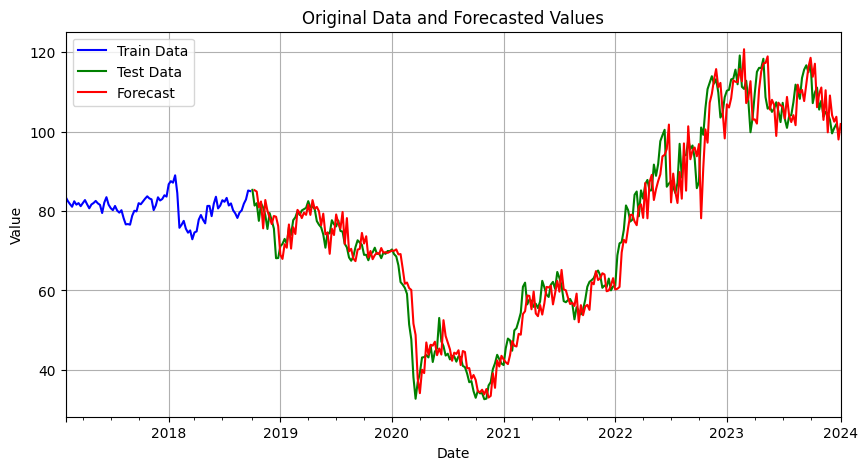

In [ ]:
# Get the first timestamp
start = s_test.index[1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start, periods=len(c_preds), freq=f)

# Convert the predictions to a pandas Series
pred_series = pd.Series(c_preds, index=future_dates, name='Forecast')
mypred_series = pred_series
#print(pred_series)

# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Train Data', color='blue')
s_test.plot(ax=ax, label='Test Data', color='green')
pred_series.plot(ax=ax, label='Forecast', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create the DataFrame
preds = preds[:len(s_test)]  # truncate preds if too long
c_preds = c_preds[:len(s_test)]  # truncate preds if too long
s_test = s_test.iloc[:len(preds)]  # truncate s_test if too long (if needed)

comparison = pd.DataFrame({
    'True': s_test.values,
    'ARIMA': preds,
    'c ARIMA': c_preds
}, index=s_test.index)

# Add 'Previous' column
comparison.insert(0, 'Previous', comparison['True'].shift(1))

# Fill the first 'Previous' with last value of training set
comparison.iloc[0, comparison.columns.get_loc('Previous')] = s_train.iloc[-1]

# Add 'True Difference' and 'Predicted Difference' columns
comparison['True Difference'] = comparison['True'] - comparison['Previous']
comparison['ARIMA Predicted Difference'] = comparison['ARIMA'] - comparison['Previous']
comparison['c ARIMA Predicted Difference'] = comparison['c ARIMA'] - comparison['Previous']

# Show it
comparison.tail(40)


,Previous,True,ARIMA,c ARIMA,True Difference,ARIMA Predicted Difference,c ARIMA Predicted Difference
date,,,,,,,
2023-04-02,103.53,109.66,95.173845,102.019990,6.13,-8.356155,-1.510010
2023-04-09,109.66,115.05,107.572452,110.618889,5.39,-2.087548,0.958889
2023-04-16,115.05,116.05,110.091993,115.130562,1.00,-4.958007,0.080562
2023-04-23,116.05,116.01,113.727021,117.180496,-0.04,-2.322979,1.130496
2023-04-30,116.01,118.34,111.053122,117.289961,2.33,-4.956878,1.279961
2023-05-07,118.34,108.68,112.165944,118.948284,-9.66,-6.174056,0.608284
2023-05-14,108.68,105.78,98.629212,105.562595,-2.90,-10.050788,-3.117405
2023-05-21,105.78,106.26,103.534113,108.005506,0.48,-2.245887,2.225506
2023-05-28,106.26,104.97,101.253054,106.754559,-1.29,-5.006946,0.494559


In [ ]:
# Define a threshold for strong predicted differences
threshold = 2  # Replace t with your actual threshold value

# Filter rows where the predicted difference is greater than the threshold
mask = comparison['ARIMA Predicted Difference'] > threshold
filtered = comparison[mask]
# Compute conditional directional accuracy
conditional_directional_accuracy = 100 * (
    np.sign(filtered['True Difference']) == np.sign(filtered['ARIMA Predicted Difference'])
).mean()

# Filter rows where the predicted difference is greater than the threshold
mask = comparison['c ARIMA Predicted Difference'] > threshold
filtered = comparison[mask]
# Compute conditional directional accuracy
c_conditional_directional_accuracy = 100 * (
    np.sign(filtered['True Difference']) == np.sign(filtered['c ARIMA Predicted Difference'])
).mean()




directional_accuracy = 100 * (np.sign(comparison['True Difference']) == np.sign(comparison['ARIMA Predicted Difference'])).mean()
c_directional_accuracy = 100 * (np.sign(comparison['True Difference']) == np.sign(comparison['c ARIMA Predicted Difference'])).mean()

# MSE and MAE
mse = mean_squared_error(comparison['True'], comparison['ARIMA'])
mae = mean_absolute_error(comparison['True'], comparison['ARIMA'])
c_mse = mean_squared_error(comparison['True'], comparison['c ARIMA'])
c_mae = mean_absolute_error(comparison['True'], comparison['c ARIMA'])

print("ARIMA:")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")
print(f"Conditional Directional Accuracy (predicted > {threshold}): {conditional_directional_accuracy:.2f}%")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print('')
print("Contextualised ARIMA:")
print(f"Directional Accuracy: {c_directional_accuracy:.2f}%")
print(f"Conditional Directional Accuracy (predicted > {threshold}): {c_conditional_directional_accuracy:.2f}%")
print(f"Mean Squared Error (MSE): {c_mse:.4f}")
print(f"Mean Absolute Error (MAE): {c_mae:.4f}")

ARIMA:
Directional Accuracy: 48.18%
Conditional Directional Accuracy (predicted > 2): 52.00%
Mean Squared Error (MSE): 37.6549
Mean Absolute Error (MAE): 4.7835

Contextualised ARIMA:
Directional Accuracy: 48.18%
Conditional Directional Accuracy (predicted > 2): 58.62%
Mean Squared Error (MSE): 14.9443
Mean Absolute Error (MAE): 2.8690


In [ ]:
filtered

,Previous,True,ARIMA,c ARIMA,True Difference,ARIMA Predicted Difference,c ARIMA Predicted Difference
date,,,,,,,
2019-01-27,72.99,71.72,77.966343,76.619021,-1.27,4.976343,3.629021
2019-02-24,77.71,78.42,81.269482,80.294116,0.71,3.559482,2.584116
2019-05-19,76.56,75.91,82.278414,79.336626,-0.65,5.718414,2.776626
2019-07-21,77.63,74.99,83.180448,79.769592,-2.64,5.550448,2.139592
2019-08-04,74.81,71.75,81.259067,78.222150,-3.06,6.449067,3.412150
2019-10-06,71.48,68.97,77.040672,73.657942,-2.51,5.560672,2.177942
2020-04-05,36.95,39.21,42.327131,40.050051,2.26,5.377131,3.100051
2020-04-19,43.13,43.22,52.208331,46.908620,0.09,9.078331,3.778620
2020-05-03,43.73,43.14,52.480415,46.333734,-0.59,8.750415,2.603734


In [ ]:
# Filter high-confidence ARIMA predictions
buys = comparison[comparison['c ARIMA Predicted Difference'] > 2]

# Create the figure
fig = go.Figure()

# Plot true values
fig.add_trace(go.Scatter(
    x=comparison.index,
    y=comparison['True'],
    name='True',
    mode='lines+markers'
))

# Add green up arrows where model predicts strongly upwards
fig.add_trace(go.Scatter(
    x=buys.index,
    y=buys['True'],
    mode='markers',
    marker=dict(color='green', size=15, symbol='triangle-up'),
    name='ContextARIMA Buy Signal'
))

# Update layout for clarity
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    height=600,
    legend=dict(x=0.01, y=0.99)
)

fig.show()


In [ ]:
for t in [0,0.5, 1, 1.5, 2, 2.5]:
    # Filter high-confidence ARIMA predictions
    buys = comparison[comparison['c ARIMA Predicted Difference'] > t]
    buys['Realized Return (%)'] = buys['True Difference'] / buys['Previous'] * 100
    mean_return = buys['Realized Return (%)'].mean()
    print(t)
    print(f"Mean realized return: {mean_return:.2f}%")
    # Compute cumulative return assuming full reinvestment
    cumulative_return = (1 + buys['Realized Return (%)']/100).prod() - 1
    # Also display as %
    print(f"Cumulative return from all high-confidence buy signals: {cumulative_return * 100:.2f}%")
    hit_rate = (buys['True Difference'] > 0).mean() * 100

    print(f"Hit rate (positive return): {hit_rate:.2f}%")


0
Mean realized return: -0.02%
Cumulative return from all high-confidence buy signals: -18.50%
Hit rate (positive return): 51.47%
0.5
Mean realized return: 0.15%
Cumulative return from all high-confidence buy signals: 0.71%
Hit rate (positive return): 54.08%
1
Mean realized return: 0.25%
Cumulative return from all high-confidence buy signals: 6.60%
Hit rate (positive return): 56.52%
1.5
Mean realized return: 0.76%
Cumulative return from all high-confidence buy signals: 35.66%
Hit rate (positive return): 60.00%
2
Mean realized return: 0.72%
Cumulative return from all high-confidence buy signals: 19.79%
Hit rate (positive return): 58.62%
2.5
Mean realized return: 1.33%
Cumulative return from all high-confidence buy signals: 25.78%
Hit rate (positive return): 63.16%


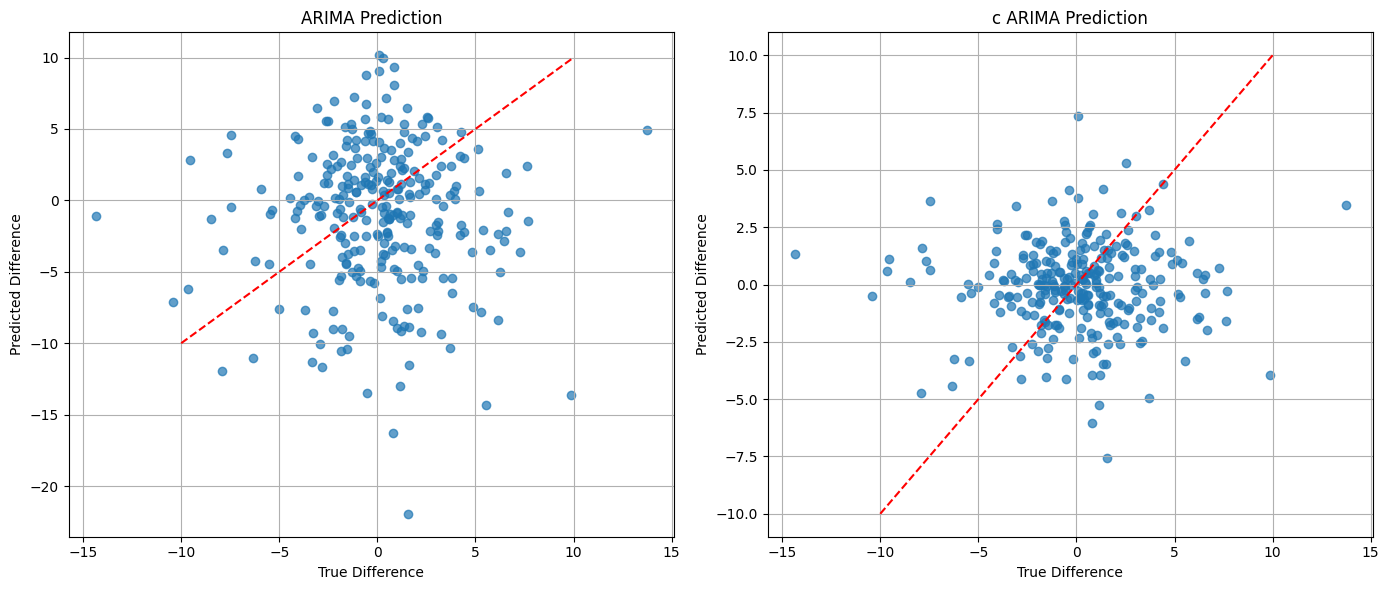

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# --- Left plot ---
axes[0].scatter(comparison['True Difference'], comparison['ARIMA Predicted Difference'], alpha=0.7)
axes[0].plot([-10, 10], [-10, 10], 'r--')  # 45-degree line
axes[0].set_title('ARIMA Prediction')
axes[0].set_xlabel('True Difference')
axes[0].set_ylabel('Predicted Difference')
axes[0].grid(True)

# --- Right plot (placeholder — duplicate or use different model if you like) ---
axes[1].scatter(comparison['True Difference'], comparison['c ARIMA Predicted Difference'], alpha=0.7)
axes[1].plot([-10, 10], [-10, 10], 'r--')
axes[1].set_title('c ARIMA Prediction')
axes[1].set_xlabel('True Difference')
axes[1].set_ylabel('Predicted Difference')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Assume that model_dict, df, and forecast() are already defined.
forecast_steps = 45
preds = forecast(model_dict, forecast_steps)
c_preds = c_forecast(c_model_dict, C_df, forecast_steps)

ValueError: only leading negative signs are allowed

In [ ]:
c_preds

[array([85.70213208]),
 array([85.47814278]),
 array([85.52890901]),
 array([85.49394358]),
 array([84.84158045]),
 array([84.11441723]),
 array([84.19208478]),
 array([84.1161311]),
 array([83.61359552]),
 array([83.96940906]),
 array([84.29766677]),
 array([84.3366183]),
 array([84.57134432]),
 array([84.81731194]),
 array([84.88291794]),
 array([84.94379809]),
 array([84.60103788]),
 array([84.26486794]),
 array([84.33740551]),
 array([84.13123074]),
 array([84.07965041]),
 array([84.45749589]),
 array([84.80262243]),
 array([84.8392315]),
 array([85.13674937]),
 array([85.3007065]),
 array([85.39078409]),
 array([85.48390533]),
 array([85.38947681]),
 array([85.26430627]),
 array([85.26994668]),
 array([85.09949043]),
 array([84.9581498]),
 array([85.07537841]),
 array([85.07200297]),
 array([85.03775555]),
 array([85.16953153]),
 array([85.27163661]),
 array([85.33003414]),
 array([85.45554575]),
 array([85.4565578]),
 array([85.44036902]),
 array([85.46631794]),
 array([85.370719

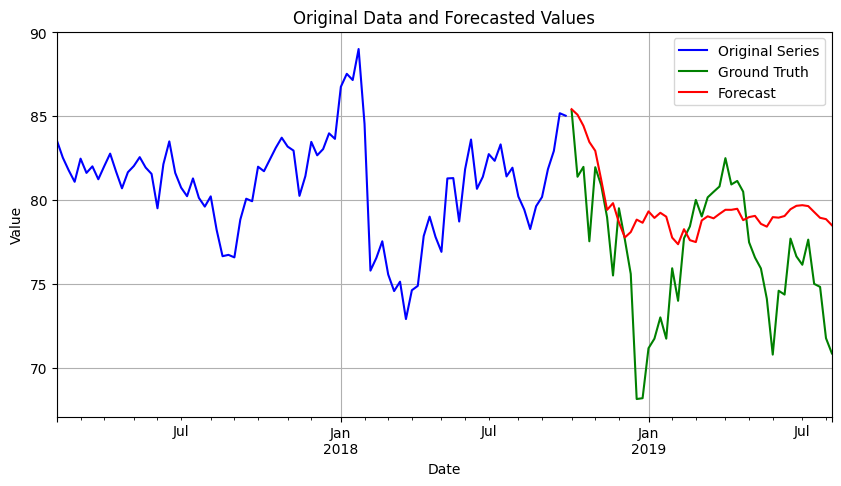

In [ ]:
# Get the last timestamp from the original series
last_date = s_train.index[-1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(s_train.index[-1], periods=forecast_steps + 1, freq=f)[1:]

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
#print(pred_series)


# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Original Series', color='blue')
s_test.iloc[:1*forecast_steps].plot(ax=ax, label='Ground Truth', color='green')
pred_series.plot(ax=ax, label='Forecast', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()